# The impact of parameters on the performance of random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

One of our goals in this repository is to forecast the number of available seats, say over the next two weeks, and random forests are one such technique.

In this notebook we investigate the impact of the parameters on the performance of the model.  

## The features used in the models
This notebook was initially based on lessons from fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  There, the timestamp in the dataset was expanded to 15 default features using the function `add_datepart` from the fastai library.  In our case, the data is a pure time-series, and in retrospect it is easy guess which two features are sufficient (this is discussed in the notebook `la-permanence-random-forests-feature-importance.ipynb`).  However, in the process we built tools which should prove useful in the general case and for the purpose of exposition we keep all experimentation in this notebook.



## Model parameters
There are many parameters in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that can be adjusted in order to improve the predictions.  These include the following.  
-  The number of trees: `n_estimators`; the default value is (currently) **10**.   
-  The maximum depth: `max_depth`;  the default is `None`, i.e. no maximum.  
-  The minimum number of samples required to be at a leaf node: `min_samples_leaf`; the default value is **1**.  
-  The maximum number of features to consider when looking for the best split: `max_features`; the default is to use **all** features.  
While the parameters `max_depth` and `min_samples_leaf` can both be set independently, here we will consider them separately.



## Metrics used to assess model performance

We will use the root mean squared error (RMSE) and $R^2$ score to assess the predictions.  If various models are applied to the same dataset, then RMSE and $R^2$ provide the same qualitative information, in the sense that optimal choices of the model's parameters are the same whether the metric used is RMSE or $R^2$.  



## The fastai library
The code in this notebook follows closely lessons 1 through 4 of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  The corresponding notebooks from the course's github repository are [lesson1-rf.ipynb and lesson2-rf-interpretation.ipynb](https://github.com/fastai/fastai/tree/master/courses/ml1).  This notebook uses [version 0.7](https://github.com/fastai/fastai/tree/master/old/fastai) of the fastai library.

## Imports, constants, and functions

In [1]:
# =======
# IMPORTS
# =======

import os
import sys
import re
# import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

# =========
# CONSTANTS
# =========

    # Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 2  # 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# PLOTTING PARAMETERS
FIGSIZE = (16, 6)
ALPHA = 0.7

# Colors
# COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

# =========
# FUNCTIONS
# =========

def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## Load and preprocess data

The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  


The dataset consists of pure time-series:
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
  - `YYYY=year`,
  - `MM=month`,
  - `DD=day`,
  - `hh=hour`,
  - `mm=minute`,
  - `ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

If we are to use random forests, or decision trees, on the data, we need to convert the `timestamp` into a set of categorical features.  As an initial point we will use the function `add_datepart` from the [fastai library](https://github.com/fastai/fastai/blob/master/old/fastai/structured.py) (version 0.7).  Specifically, we will add the following features:  
- `Year`,
- `Month`,
- `Week`,
- `Day`,
- `Dayofweek`,
- `Dayofyear`,
- `Is_month_end`,
- `Is_month_start`,
- `Is_quarter_end`,
- `Is_quarter_start`,
- `Is_year_end`,
- `Is_year_start`,
- `Hour`,
- `Minute`,
- `Second`.  

Of course many will play absolutely no role, and we will find criteria to decide exactly which features to retain and why.


In [2]:
# %%prun
%time

# =========
# METADATA ON THE DATA
# =========

filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20

print("")

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

# =========
# LOAD DATA
# =========

print("\nLoad data...")
raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

# ========================
# ADJUSTING FOR TIMEZONES
# The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:
# ========================

print("Adjust for timezones...")
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

# ===================
# TIME REGULARIZATION
# The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:
# ===================

print("Perform time regularization...")
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

# ==========================
# EXPAND DATE INFORMATION
# Create new features from `timestamp` to pass to decision tree
# ==========================

print("Expand date information...")
timestamps = raw_data.loc[:, ['timestamp']]
add_datepart(raw_data, 'timestamp', time=True)

print("Done.")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs

File size:          1MB
Number of rows:     46369
Names of columns:   timestamp, Moulin, Alésia

Load data...
Adjust for timezones...
Perform time regularization...
Expand date information...
Done.


### Separating dependent from independent variables  
The following could be done by hand, but the custom function `proc_df` can perform additional transformations which are useful in the general case.

In [3]:
df, y, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

### Splitting data into training and validation sets  

In [4]:
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

## Random forests with `min_samples_leaf` prescribed
(as opposed to `max_depth`)

### Running the model with default values

We first use random forests with default values.  

**Note.**  As of now (March 2019), the default value for `n_estimators` in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) is 10, although it will be changed to 100.  

In [5]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 1.15 s, sys: 23.7 ms, total: 1.17 s
Wall time: 256 ms
RMSE (train)        : 0.22166557106480517
RMSE (validation)   : 7.760890517652219
R2 (train)          : 0.9998388352110872
R2 (validation)     : 0.8458040892688858


The performance as measured on the training set, not suprisingly, is  very high, but those on the validation set are  nevertheless promising given that we are using default parameters.

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


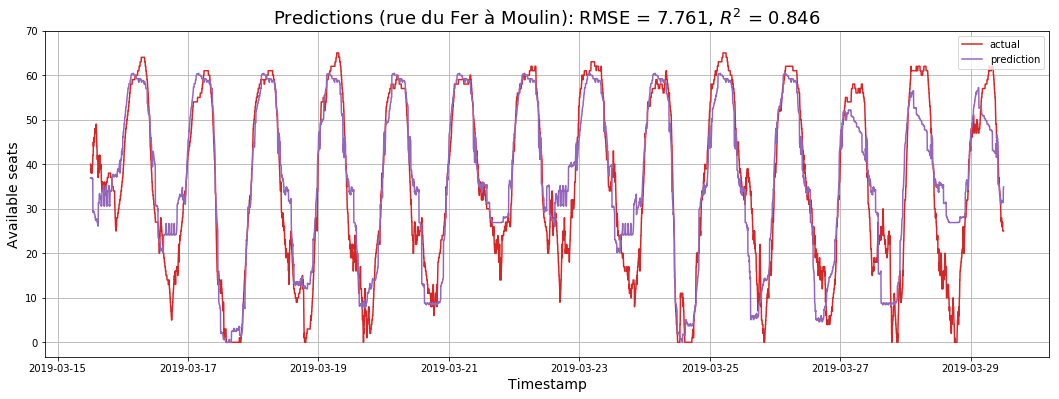

In [6]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Predictions (rue du Fer à Moulin): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid)
    ),
    fontsize=18
)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();

### First impressions
Depending on the run, the results may be unimpressive or very encouraging.  In any case, it should be clear that random forests are at least reasonably effective at picking up the general behavior of the seat availability, and where they do not perform so well is when the availability is particularly low or high.

One key observation is that increasing the number of trees will improve the stability of the results.  Before investigating the effect of taking a high value for `n_estimators`, we perform a grid search over a range of values for the other two parameters of interest, `min_samples_leaf` and `max_features`.

Thus for the moment we fix

In [7]:
n_estimators = 10

## A quick scan through `min_samples_leaf` and `max_features`

We measure the RMSE and the $R^2$ score for a range of parameter values:

In [8]:
MIN_SAMPLES_LEAF = [2**i for i in range(10)]
MAX_FEATURES = range(1, len(df.columns)+1, 2)

performance_list = []

for i, j in tqdm([(x, y) for x in MIN_SAMPLES_LEAF for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min_samples_leaf': i,
        'max_features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 80/80 [00:31<00:00,  2.58it/s]


In [9]:
performance = pd.DataFrame(performance_list)[['min_samples_leaf', 'max_features', 'rmse', 'R2']]

df_rmse = pd.pivot_table(performance, index='min_samples_leaf', columns='max_features', values='rmse')
df_r2 = pd.pivot_table(performance, index='min_samples_leaf', columns='max_features', values='R2')

Plot heatmaps for RMSE and $R^2$:

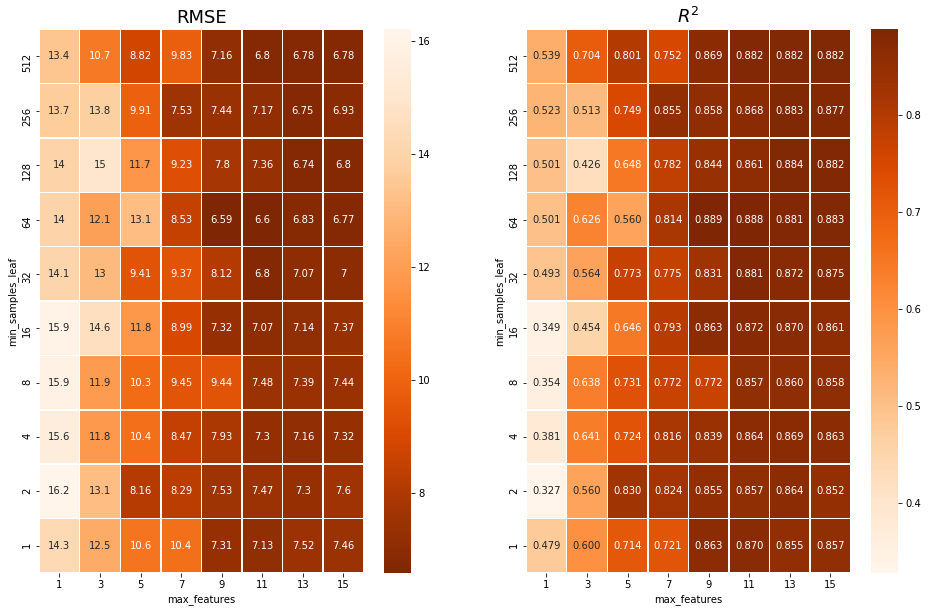

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10));
plt.subplots_adjust(wspace=0.2);
sns.heatmap(df_rmse.sort_index(ascending=False), annot=True, cmap="Oranges_r", linewidths=.5, fmt='.3g', ax=ax1);
ax1.set_title("RMSE", fontsize=18);
sns.heatmap(df_r2.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=.5, fmt='.3f', ax=ax2);
ax2.set_title("$R^2$", fontsize=18);

**Remark on the color maps.**  The color maps are so chosen that in both cases *darker colors mean better results*.  However, since we do not wish to compare RMSE and $R^2$, colors for one metric are not meant to correspond to color for the other.  

**Observations.**  
The heatmaps show a decent level of regularity and thus we can reasonably conclude that they give the correct picture.  At this point (and depending on the outcome of the simulation), the heatmaps may suggest that  
1. a higher number of features generally provides better results; and that  
1. the better results are obtained for `min_samples_leaf` that are not too large, say no more than 256, and not too small, say greater than 4.  


For the particular grid search above we can extract the optimizer:

In [11]:
sort_performance = performance.sort_values('R2')[['min_samples_leaf', 'max_features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_samples_leaf, max_features, min_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_samples_leaf = int(min_samples_leaf)
max_features = int(max_features)

COL_WIDTH = 25
print("{0}: {1}".format("optimal max_features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("optimal min_samples_leaf".ljust(COL_WIDTH), min_samples_leaf))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), min_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

optimal max_features     : 9
optimal min_samples_leaf : 64
max RMSE                 : 6.5857
max R2                   : 0.8890


## A more thorough search through `min_samples_leaf` and `max_features`

We now have a relatively good idea of the range of values for the parameters that should be searched.  We fix:

In [12]:
# MIN_SAMPLES_LEAF = [2**i for i in range(10)]
# MIN_SAMPLES_LEAF = [i**2 for i in range(1, 21)]
# MIN_SAMPLES_LEAF = [int(i+0.5*i**2) for i in range(1, 20)]
# MIN_SAMPLES_LEAF = [int(i+0.2*i**2) for i in range(1, 50)]
MIN_SAMPLES_LEAF = [int(i+0.15*i**2) for i in range(1, 55)]
MAX_FEATURES = range(len(df.columns) // 2, len(df.columns)+1)
MIN_SAMPLES_LEAF[0], MIN_SAMPLES_LEAF[-1], MAX_FEATURES[0], MAX_FEATURES[-1]

(1, 491, 8, 16)

For comparison, we calculate again the performance for a low value of `n_estimators` as above:

In [13]:
n_estimators

10

In [14]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_SAMPLES_LEAF for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min_samples_leaf': i,
        'max_features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 486/486 [03:09<00:00,  2.58it/s]


In [15]:
performance_low_n_estimators = pd.DataFrame(performance_list)[['min_samples_leaf', 'max_features', 'rmse', 'R2']]
df_rmse_low_n_estimators = pd.pivot_table(performance_low_n_estimators, index='min_samples_leaf', columns='max_features', values='rmse')
df_r2_low_n_estimators = pd.pivot_table(performance_low_n_estimators, index='min_samples_leaf', columns='max_features', values='R2')

Repeat with (many) more trees:

In [16]:
n_estimators_high = 10*n_estimators
n_estimators_high

100

In [17]:
performance_list = []

for i, j in tqdm([(x, y) for x in MIN_SAMPLES_LEAF for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators_high, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min_samples_leaf': i,
        'max_features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 486/486 [07:54<00:00,  1.11it/s]


In [18]:
performance_high_n_estimators = pd.DataFrame(performance_list)[['min_samples_leaf', 'max_features', 'rmse', 'R2']]
df_rmse_high_n_estimators = pd.pivot_table(performance_high_n_estimators, index='min_samples_leaf', columns='max_features', values='rmse')
df_r2_high_n_estimators = pd.pivot_table(performance_high_n_estimators, index='min_samples_leaf', columns='max_features', values='R2')

Plot the $R^2$ scores for low and high number of trees with the same color map, that is, the same minimum and maximum values:

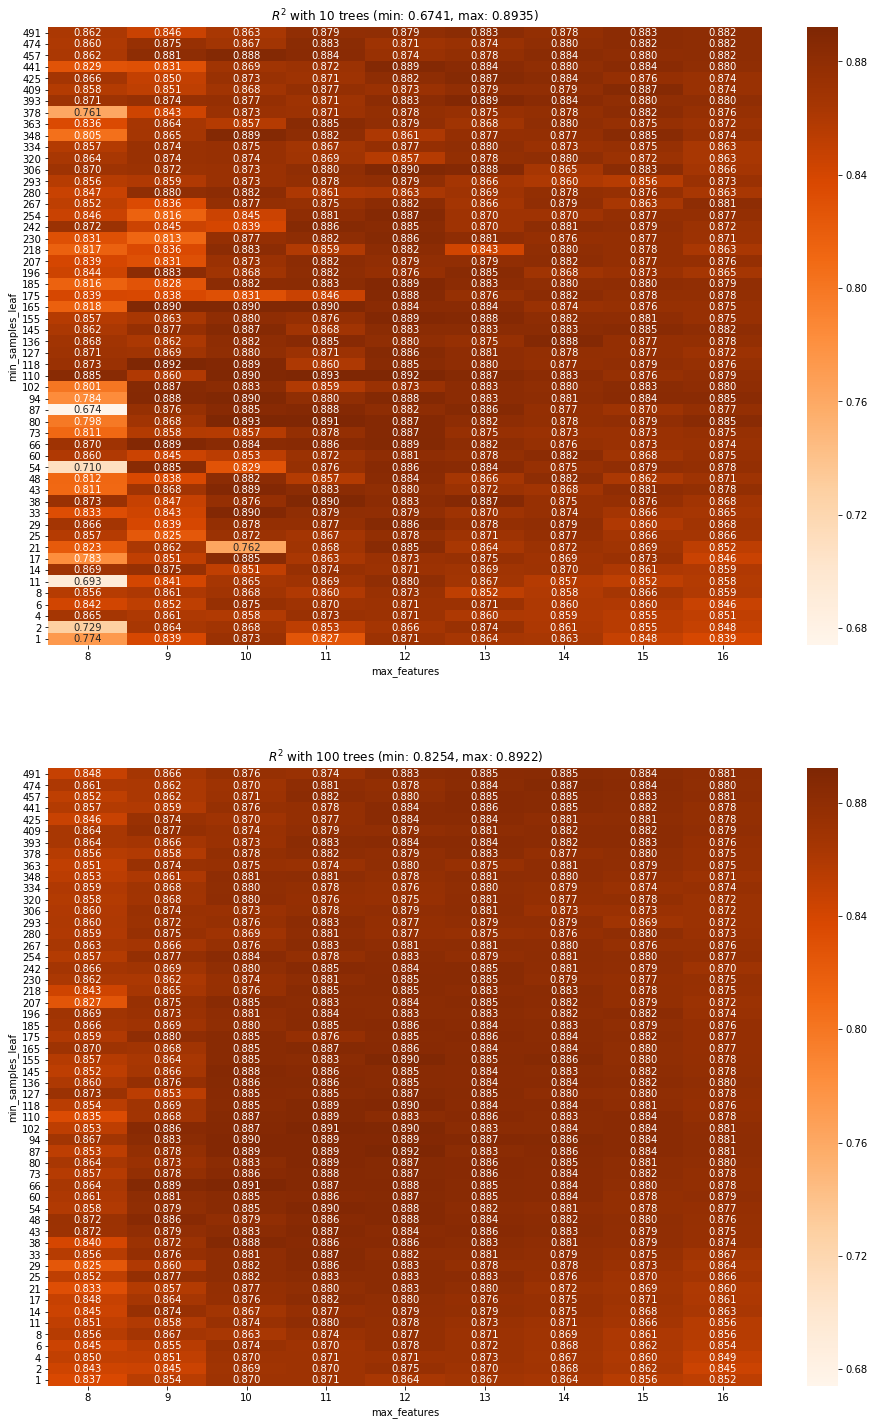

In [19]:
vmin = min(performance_low_n_estimators['R2'].min(), performance_high_n_estimators['R2'].min())
vmax = min(performance_low_n_estimators['R2'].max(), performance_high_n_estimators['R2'].max())

fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(16, 25));
plt.subplots_adjust(wspace=0.1);
sns.heatmap(df_r2_low_n_estimators.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax1);
ax1.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        n_estimators,
        performance_low_n_estimators['R2'].min(),
        performance_low_n_estimators['R2'].max()
    )
);
sns.heatmap(df_r2_high_n_estimators.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax2);
ax2.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        n_estimators_high,
        performance_high_n_estimators['R2'].min(),
        performance_high_n_estimators['R2'].max()
    )
);

# plt.savefig("R2-with-low-and-high-number-of-trees-heatmaps.png")

We do observe the regularizing effect of taking a higher `n_estimators`.  

We can "zoom in" on the optimal values via the parameter `vmin`:

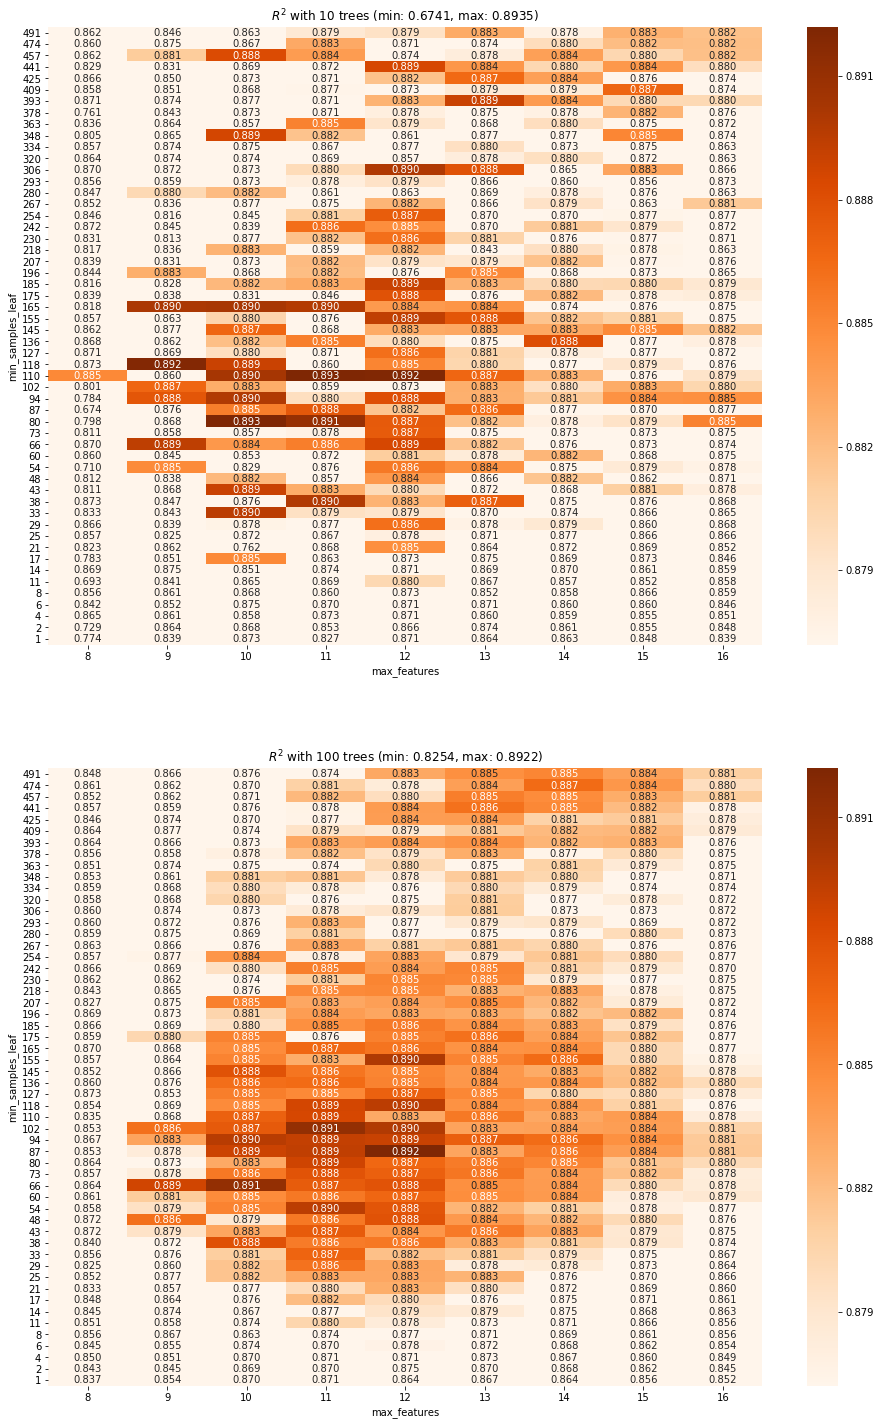

In [20]:
vmax = min(performance_low_n_estimators['R2'].max(), performance_high_n_estimators['R2'].max())
vmin = vmax - 0.015

fig, (ax1, ax2) = plt.subplots(2, 1 , figsize=(16, 25));
plt.subplots_adjust(wspace=0.1);
sns.heatmap(df_r2_low_n_estimators.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax1);
ax1.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        n_estimators,
        performance_low_n_estimators['R2'].min(),
        performance_low_n_estimators['R2'].max()
    )
);
sns.heatmap(df_r2_high_n_estimators.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=0, fmt='.3f', vmin=vmin, vmax=vmax, ax=ax2);
ax2.set_title(
    "$R^2$ with {0} trees (min: {1:.4f}, max: {2:.4f})".format(
        n_estimators_high,
        performance_high_n_estimators['R2'].min(),
        performance_high_n_estimators['R2'].max()
    )
);

Identify the optimizers, that is, the values of the parameters `max_features` and `min_samples_leaf` yielding a $R^2$ score closer to 1 (equivalently a lower value of RMSE):

In [21]:
sort_performance = performance_low_n_estimators.sort_values('R2')[['min_samples_leaf', 'max_features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_samples_leaf, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_samples_leaf = int(min_samples_leaf)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(n_estimators))
print("{0}: {1}".format("optimal max_features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("optimal min_samples_leaf".ljust(COL_WIDTH), min_samples_leaf))
print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 10 trees:
optimal max_features     : 10
optimal min_samples_leaf : 80
max RMSE                 : 6.4512
max R2                   : 0.8935


In [22]:
sort_performance = performance_high_n_estimators.sort_values('R2')[['min_samples_leaf', 'max_features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

min_samples_leaf, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
min_samples_leaf = int(min_samples_leaf)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(n_estimators_high))
print("{0}: {1}".format("optimal max_features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("optimal min_samples_leaf".ljust(COL_WIDTH), min_samples_leaf))

print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 100 trees:
optimal max_features     : 12
optimal min_samples_leaf : 87
max RMSE                 : 6.4893
max R2                   : 0.8922


### Observations and conclusions

By "performance" we understand a model's ability to achieve a low RMSE or equivalently a high $R^2$ (i.e. near 1).

1. The heatmap with higher number of trees exhibits a lot more regularity as can be expected.  Indeed, random forests produce their predictions by averaging over a number of trees, which ideally should be independent of one another.  For each pair of values of the parameters `max_features` and `min_samples_leaf`, the variation of the output decreases with a large number of trees.  On the other hand, it is reasonable to think that the performance of random forests varies smoothly across the parameter space. This is of course not a rigorous statement but intuitively the regularity across the values for the parameters `max_features` and `min_samples_leaf`, for a large number of trees, should reflect the stabilizing effect of taking averages.  
1.  The better performance with a low number of trees is consistent with the higher variability of the results.  In other words, using fewer trees we may have more luck in achieving better results.  On the other hand, the value of the parameters optimizing the results may vary greatly, as does the performance.  
1.  The metrics are not monotonic functions of the parameters `max_features` and `min_samples_leaf`, with what appears to be two local optima.  However, the metrics vary smoothly with `max_features` and `min_samples_leaf` provided `n_estimators` is high (e.g. 100).  This regularity is also visible in the stability of the results from one run of simulation to the next.  Unfortunately, the shape of these metrics as functions of `max_features` and `min_samples_leaf` do change noticeably as the (training) dataset changes (after each update).  It is therefore difficult to draw general conclusions as to why the optimizers are what they are.  In fact, using the data from the other location, the shape of the metric functions can be quite different, with significantly different optimizers.  This is indication that overfitting is taking place, as the performance is too dependent on the data.  
1. There are no noticeable difference in the visualization of the forecasts when the parameters are broadly in the regions around the local optima.

We should note that, as more data is collected and recorded, the value of the minimum number of samples in a leaf should vary as well.  This means that a **fraction** should be used rather than an absolute number.  

For definiteness we use the optimzing values just calculated:

In [23]:
max_features, min_samples_leaf

(12, 87)

## Visualizing the predictions


In [24]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators_high, max_features=max_features, min_samples_leaf=min_samples_leaf)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 5.82 s, sys: 29.3 ms, total: 5.85 s
Wall time: 700 ms
RMSE (train)        : 3.2416381109012877
RMSE (validation)   : 6.568614541931501
R2 (train)          : 0.9655330594756946
R2 (validation)     : 0.8895419689704468


We still a big gap in performance between the training set and the validation set.  

Let's visualize the predictions:

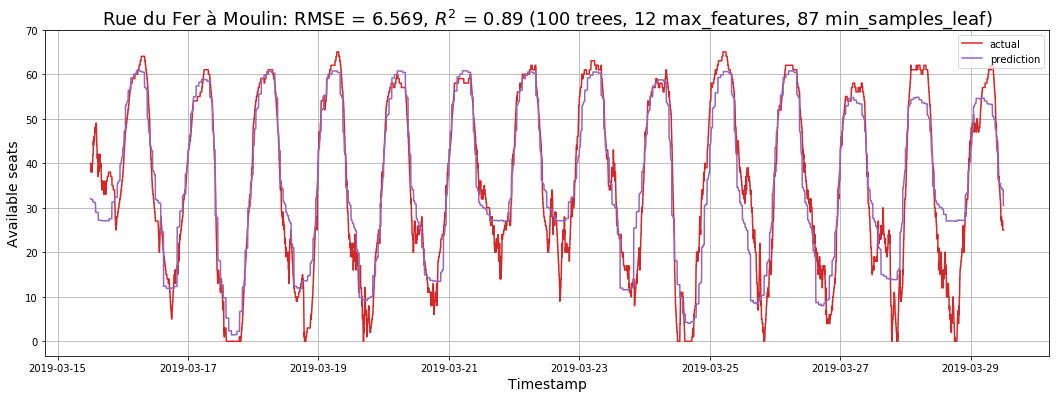

In [25]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max_features, {4} min_samples_leaf)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators_high,
        max_features,
        min_samples_leaf
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png");

# Experimenting with `max_depth`

The maximum number of available seats at the locations are 64 and 82.  If we are using a single tree, this means that it should have a depth of at least 7 if one wants to achieve all possible values for sure.  On the other hand, a random forests takes averages of decision trees.  If their performances are independent (loosely speaking) then they should produce different outputs, and averaging them should create intermediate values in between.  Nevertheless, it is reasonable to start with a depth of 7 to ensure that each tree does produce an appropriate range of values.

In [30]:
MAX_FEATURES = range(len(df.columns) // 2, len(df.columns)+1, 1)
MAX_DEPTH = range(1, 16, 1)

In [31]:
performance_list = []

for i, j in tqdm([(x, y) for x in MAX_DEPTH for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators_high, max_depth=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'max depth': i,
        'max_features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 135/135 [01:54<00:00,  1.34s/it]


In [32]:
performance = pd.DataFrame(performance_list)[['max depth', 'max_features', 'rmse', 'R2']]

df_rmse = pd.pivot_table(performance, index='max depth', columns='max_features', values='rmse')
df_r2 = pd.pivot_table(performance, index='max depth', columns='max_features', values='R2')

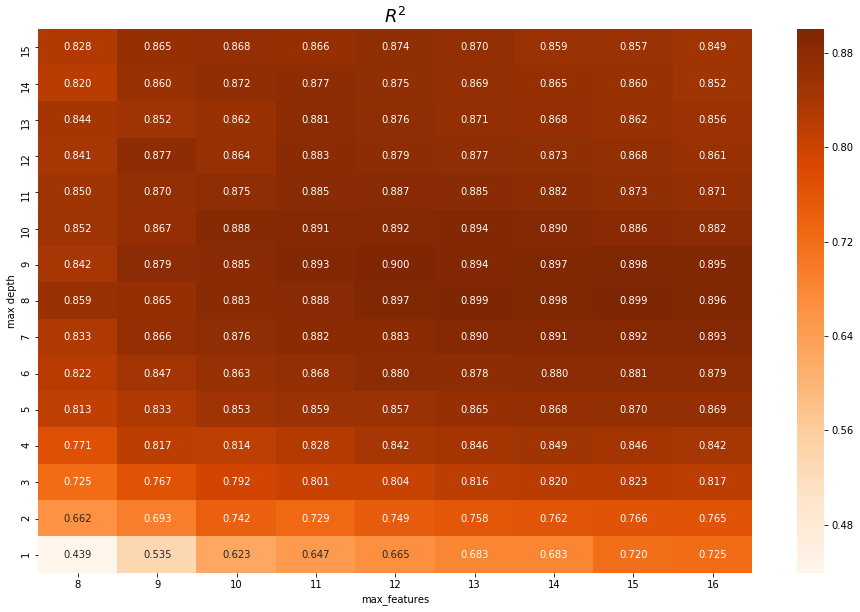

In [33]:
fig, ax = plt.subplots(figsize=(16, 10));
sns.heatmap(df_r2.sort_index(ascending=False), annot=True, cmap="Oranges",  fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

The color map makes it look like the $R^2$ score depends smoothly on the parameters and that `max_features` hardly has any effect on the results, but looking at the range of values, this could be simply an artifact of the fact that there are a few very low values.  Let's zoom in on a subset of parameter values:

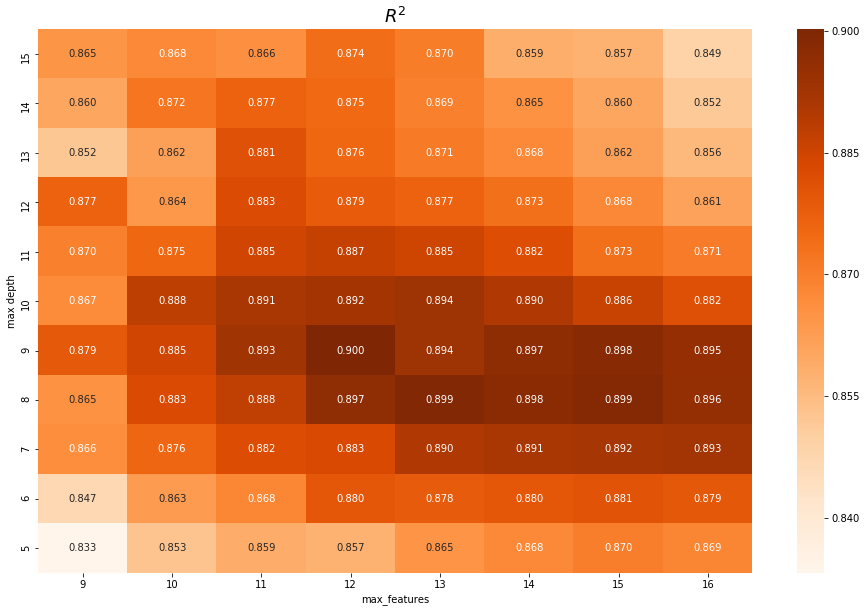

In [51]:
fig, ax = plt.subplots(figsize=(16, 10));
sns.heatmap(df_r2.sort_index(ascending=False).iloc[0:11, -8:], annot=True, cmap="Oranges",  fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

Alternatively, we can "zoom in" on the higher values:

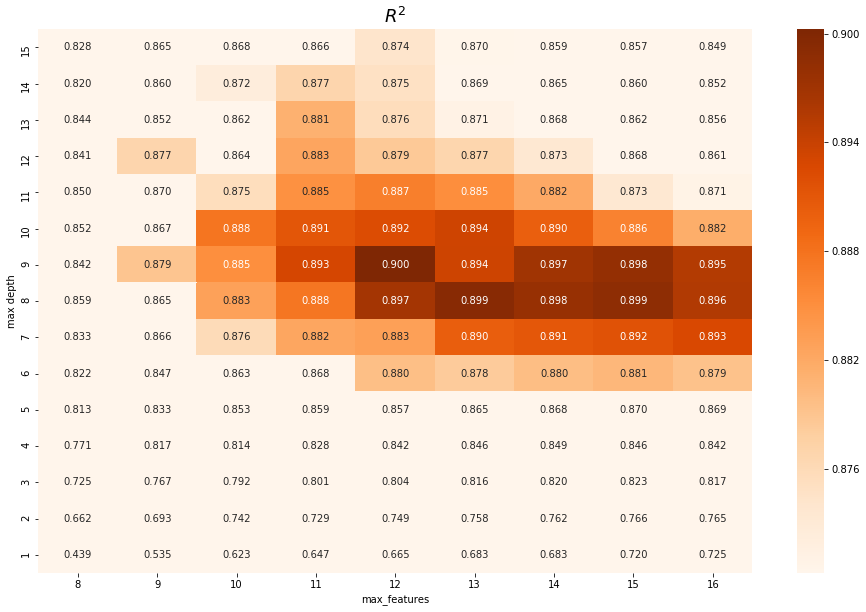

In [52]:
tol = 0.03

vmin = performance['R2'].max() - tol

fig, ax = plt.subplots(figsize=(16, 10));
sns.heatmap(df_r2.sort_index(ascending=False), vmin=vmin, annot=True, cmap="Oranges",  fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

This shows a fairly large region of near optimizers.  Since the range of values is much smaller than for the case where `min_samples_leaf` is prescribed, fixing `max_depth` appears as a more stable and robust strategy.  

In [53]:
sort_performance = performance.sort_values('R2')[['max depth', 'max_features', 'rmse', 'R2']].reset_index(drop=True)
sort_performance.head()

max_depth, max_features, max_rmse, max_r2 = tuple(sort_performance.iloc[-1])
max_depth = int(max_depth)
max_features = int(max_features)

COL_WIDTH = 25
print("Outcomes with {0} trees:".format(n_estimators_high))
print("{0}: {1}".format("optimal max_features".ljust(COL_WIDTH), max_features))
print("{0}: {1}".format("optimal max_depth".ljust(COL_WIDTH), max_depth))

print("{0}: {1:.4f}".format("max RMSE".ljust(COL_WIDTH), max_rmse))
print("{0}: {1:.4f}".format("max R2".ljust(COL_WIDTH), max_r2))

Outcomes with 100 trees:
optimal max_features     : 12
optimal max_depth        : 9
max RMSE                 : 6.2423
max R2                   : 0.9002


In [54]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators_high, max_features=max_features, max_depth=max_depth)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 5.19 s, sys: 30 ms, total: 5.22 s
Wall time: 590 ms
RMSE (train)        : 3.557019863850249
RMSE (validation)   : 6.3071946914157975
R2 (train)          : 0.9585001758411429
R2 (validation)     : 0.8981591028055109


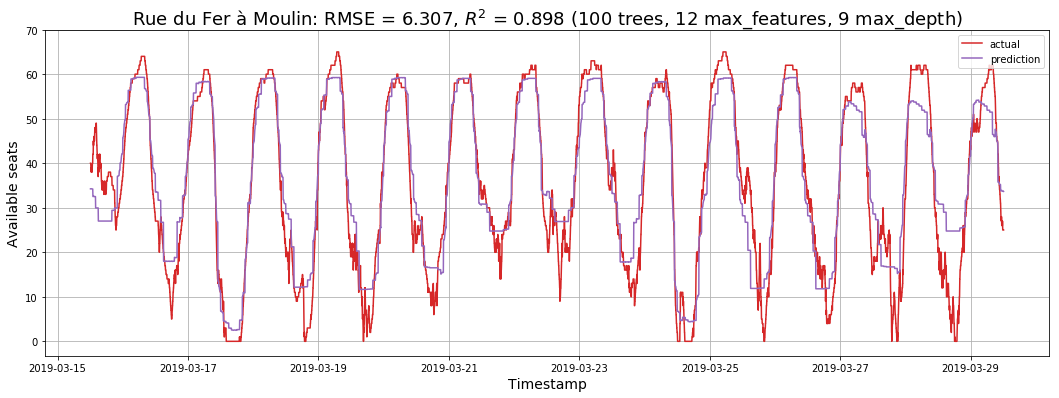

In [55]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max_features, {4} max_depth)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators_high,
        max_features,
        max_depth
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png");

# Random forests using two categorical features: `Dayofweek` and `Minuteofday`
In notebook `la-permanence-random-forests-feature-importance.ipynb` we have concluded that the best choice is to use only to categorical features extracted from the `timestamp`:

In [68]:
raw_data['timestampMinuteofday'] = 60*raw_data['timestampHour'] + raw_data['timestampMinute']

In [58]:
to_keep = ['timestamp'+feat for feat in ['Dayofweek', 'Minuteofday']]

df_keep, y_keep, nas = proc_df(raw_data[to_keep + ['Moulin']], 'Moulin')

df_keep['timestampDayofweek'].astype(np.uint8)
df_keep['timestampMinuteofday'].astype(np.uint16)

X_train, X_valid = split_vals(df_keep, n_trn)

Since there are only two features, we will let `max_features` bet set to the default `None`.

## Fixing `min_samples_leaf`

In [67]:
# MIN_SAMPLES_LEAF = [2**i for i in range(10)]
# MIN_SAMPLES_LEAF = [int(i+0.15*i**2) for i in range(1, 55)]
# MIN_SAMPLES_LEAF = range(2, 60, 4)
MIN_SAMPLES_LEAF = [int(i+0.15*i**2) for i in range(1, 55)]
N_ESTIMATORS = range(10, 110, 10)

performance_list = []

for i, j in tqdm([(x, y) for x in MIN_SAMPLES_LEAF for y  in N_ESTIMATORS]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=j, min_samples_leaf=i)
    m.fit(X_train, y_train)
    D = {
        'nb trees': j,
        'min_samples_leaf': i,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 540/540 [03:56<00:00,  2.24it/s]


In [69]:
performance = pd.DataFrame(performance_list)[['nb trees', 'min_samples_leaf', 'rmse', 'R2']]

df_r2 = pd.pivot_table(performance, index='min_samples_leaf', columns='nb trees', values='R2')

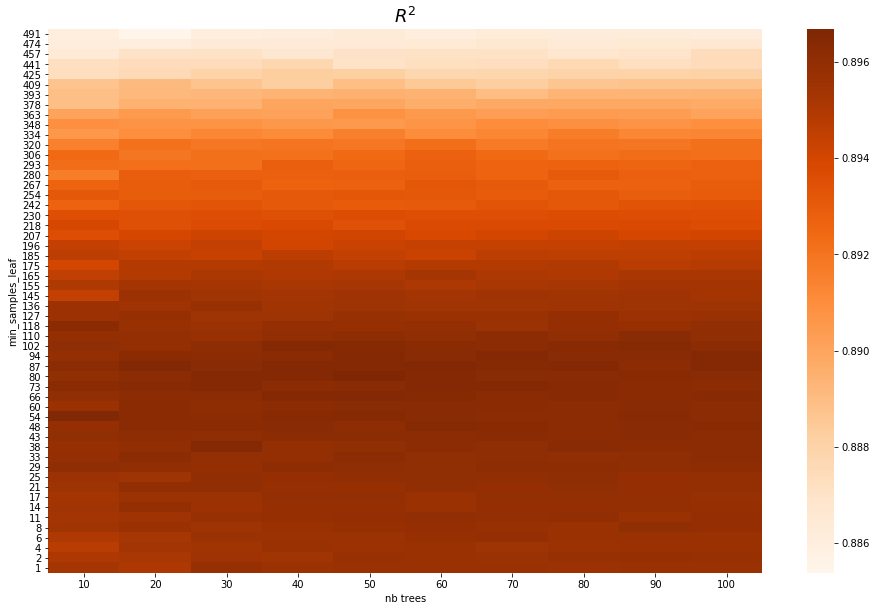

In [70]:
vmin = performance['R2'].min()
vmax = performance['R2'].max()

fig, ax = plt.subplots(figsize=(16, 10));

sns.heatmap(df_r2.sort_index(ascending=False), 
            vmin=vmin,
            vmax=vmax,
            # annot=True,
            cmap="Oranges", fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

The results with only two features are much more stable than with the naive, very large set of 16 features.  The number of trees used in the random forests play very little role.  This is because the data is actually very regular, and the features represent the output very reliably.

Let's "zoom in" on the near optimal values:

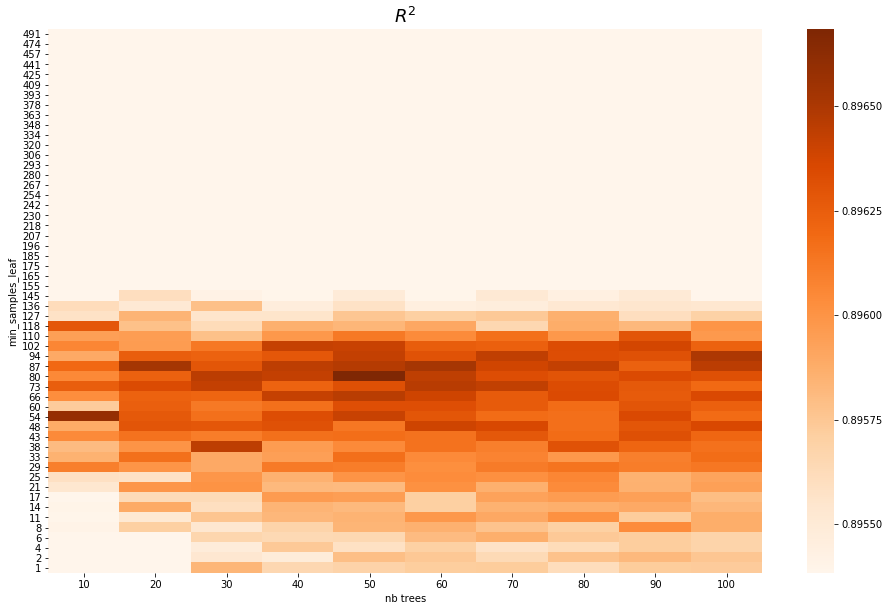

In [77]:
tol = 0.0013
vmax = performance['R2'].max()
vmin = vmax - tol


fig, ax = plt.subplots(figsize=(16, 10));

sns.heatmap(df_r2.sort_index(ascending=False), 
            vmin=vmin,
            vmax=vmax,
            # annot=True,
            cmap="Oranges", fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

Let's perform another grid search centering on lower values of `n_estimators`:

In [87]:
MIN_SAMPLES_LEAF = [int(i+0.15*i**2) for i in range(1, 55)]
N_ESTIMATORS = range(1, 21)

performance_list = []

for i, j in tqdm([(x, y) for x in MIN_SAMPLES_LEAF for y  in N_ESTIMATORS]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=j, min_samples_leaf=i)
    m.fit(X_train, y_train)
    D = {
        'nb trees': j,
        'min_samples_leaf': i,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 1080/1080 [05:40<00:00,  3.03it/s]


In [88]:
performance = pd.DataFrame(performance_list)[['nb trees', 'min_samples_leaf', 'rmse', 'R2']]

df_r2 = pd.pivot_table(performance, index='min_samples_leaf', columns='nb trees', values='R2')

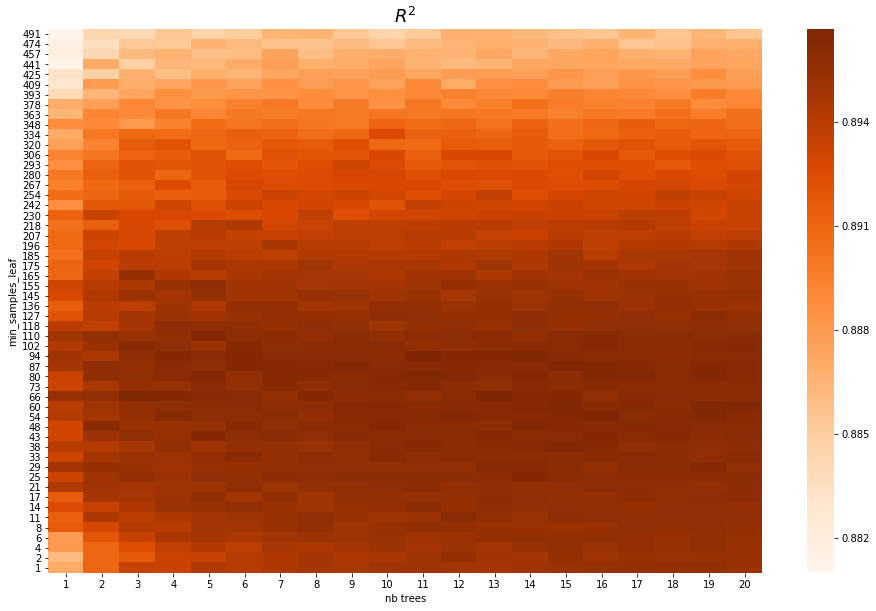

In [89]:
vmin = performance['R2'].min()
vmax = performance['R2'].max()

fig, ax = plt.subplots(figsize=(16, 10));

sns.heatmap(df_r2.sort_index(ascending=False), 
            vmin=vmin,
            vmax=vmax,
            # annot=True,
            cmap="Oranges", fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

The regularity in the colors, noting that the range is very narrow, reflects the high level of stability in the model.  

Let's "zoom in" on the near optimal values:

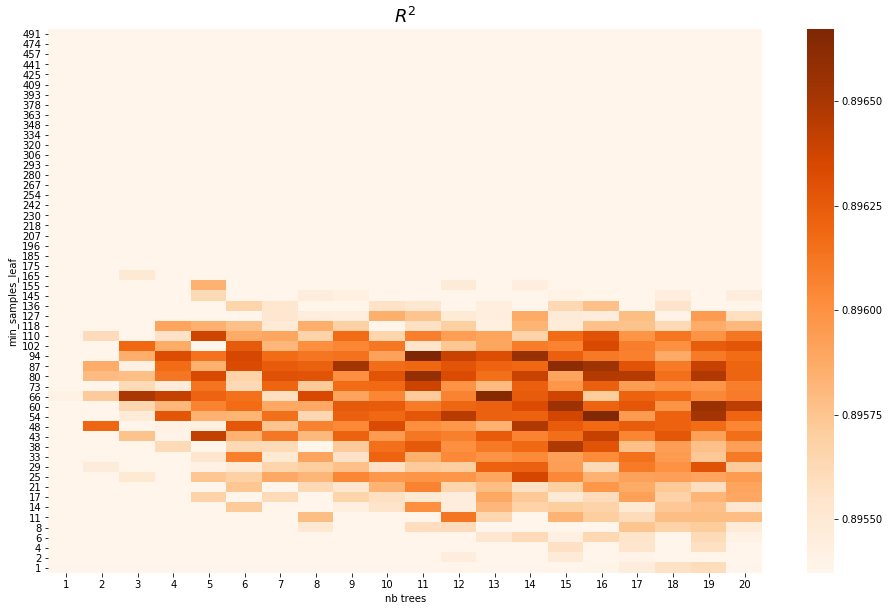

In [90]:
tol = 0.0013
vmax = performance['R2'].max()
vmin = vmax - tol

fig, ax = plt.subplots(figsize=(16, 10));

sns.heatmap(df_r2.sort_index(ascending=False), 
            vmin=vmin,
            vmax=vmax,
            # annot=True,
            cmap="Oranges", fmt='.3f', ax=ax);
ax.set_title("$R^2$", fontsize=18);

Note that each cell in this heatmap represents one trial.  However, it is difficult to imagine how the high level of regularity in parameter space could not imply a high level of consistency in the results for a fixed set of parameter values.  

Let's fix now a set of parameter values:

In [91]:
n_estimators = 10
min_samples_leaf = 100

and let's see how consistent the results are:

In [92]:
Ntrials = 100

performance_list = []

for n in tqdm(range(Ntrials)):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
    m.fit(X_train, y_train)
    D = {
        'trial': n,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

performance = pd.DataFrame(performance_list)[['trial', 'rmse', 'R2']]

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


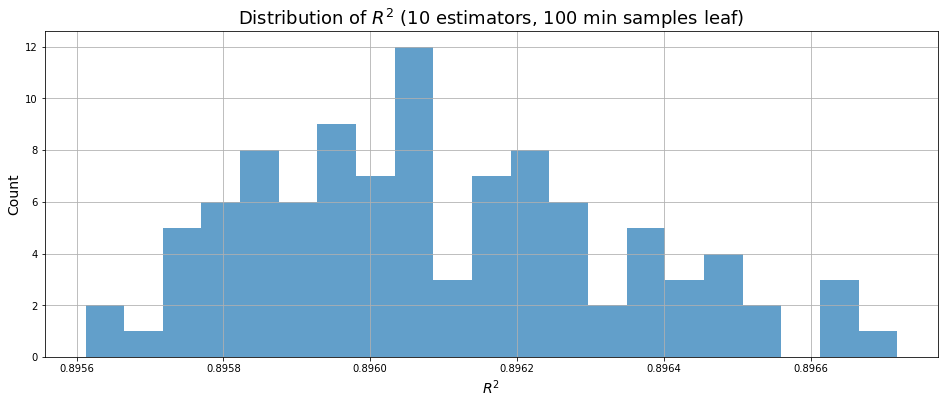

In [94]:
fig, ax = plt.subplots(figsize=(16, 6));

bins = 21

performance.hist(column='R2', bins=bins, alpha=0.7, ax=ax);
ax.set_title("Distribution of $R^2$ ({0} estimators, {1} min samples leaf)".format(n_estimators, min_samples_leaf), fontsize=18);
ax.set_xlabel("$R^2$", fontsize=14);
ax.set_ylabel("Count", fontsize=14);


The results are indeed highly consistent.  

Let's visualize the predictions for this set of parameters:

In [95]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 253 ms, sys: 9.77 ms, total: 263 ms
Wall time: 108 ms
RMSE (train)        : 5.8251178139996425
RMSE (validation)   : 6.388180340473712
R2 (train)          : 0.888703091127203
R2 (validation)     : 0.895526996991009


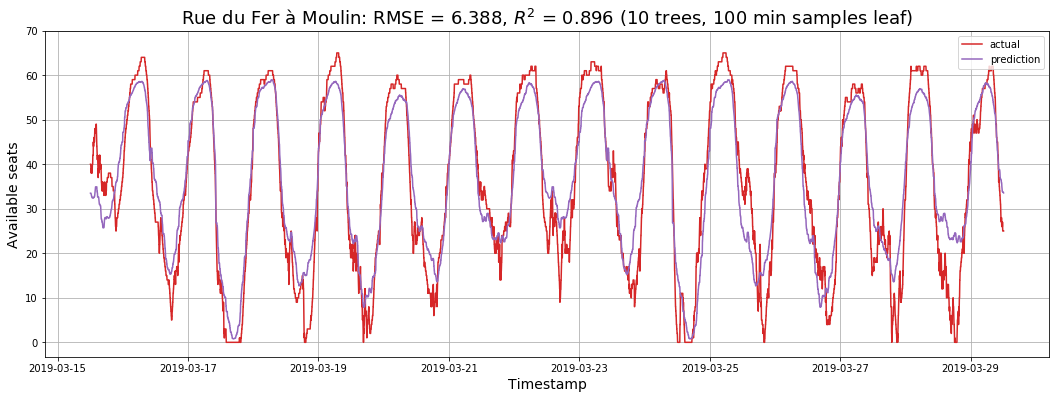

In [96]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} min samples leaf)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        n_estimators,
        min_samples_leaf
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png");